In [1]:
import pickle
import nltk
from glob import glob
from gensim.models import KeyedVectors
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext.vocab as vocab
from torch.utils.data import Dataset,DataLoader
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
import pandas as pd
import seaborn as sn

In [2]:
gensim_model = KeyedVectors.load_word2vec_format('models/1200_1507.txt')
model_vocab = gensim_model.wv.vocab

C:\Users\Owner\Anaconda3\envs\cs231n\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [4]:
class vocabulary():
    
    def __init__(self,model_vocab):
        self.word2idx = {word:model_vocab[word].index+1 for word in list(model_vocab)}
        self.pad_token = 0
        self.word2idx['<padtoken>'] = self.pad_token
        self.idx2word = {value:key for key,value in self.word2idx.items()}
        self.unkid = len(self.word2idx)
        
    def __len__(self):
        return len(self.word2idx)

    def __getitem__(self, word):
        return self.word2idx.get(word, self.unkid)

    def __contains__(self, word):
        return word in self.word2idx
    
    def id2word(self, wid):
        return self.idx2word[wid]
    
    def words2indices(self, sents):
        if type(sents[0]) == list:
            return [[self[w] for w in s] for s in sents]
        else:
            return [self[w] for w in sents]

    def indices2words(self, word_ids):
        return [self.idx2word[w_id] for w_id in word_ids]

    def pad_sents(self,sents, pad_token):
        sents_padded = []
        sents_lens = [len(sentence) for sentence in sents]
        max_sent_len = max(sents_lens)
        for sentence in sents:
            sents_padded.append(sentence)
            for _ in range(max_sent_len-len(sentence)):
                sents_padded[-1].append(pad_token)
        return sents_padded
    
    def add_words(self,word_list):
        for word in word_list:
            if self[word]==self.unkid:
                current_idx = self.unkid
                self.unkid = self.unkid+1
                self.word2idx[word]=current_idx
                self.idx2word[current_idx]=word
    
    def to_input_tensor(self,sents,device=torch.device('cuda:0')):
#         word_ids = self.words2indices(sents)
        word_ids = sents
        sents_t = self.pad_sents(word_ids, self['<padtoken>'])
        sents_var = torch.tensor(sents_t, dtype=torch.long, device=device)
        return torch.t(sents_var)

In [5]:
trial_vocab = vocabulary(model_vocab)

In [6]:
len_b4 = len(trial_vocab)
len_b4

35999

In [7]:
all_comps = pd.read_csv('Reports_2008.csv')

In [8]:
all_comps.head()

,cik,Tables,Images,Text
0,1000180,165.0,1.0,10-K 1 f38194e10vk.htm FORM 10-K e10vk Washin...
1,1000697,128.0,1.0,10-K 1 b68112wce10vk.htm WATERS CORPORATION e...
2,1001250,77.0,0.0,10-K 1 a08-22004_110k.htm 10-K Table of Conten...
3,1001288,184.0,1.0,"10-K 1 l29751ae10vk.htm LEXMARK INTERNATIONAL,..."
4,1002047,142.0,1.0,10-K 1 f38790e10vk.htm FORM 10-K e10vk Washin...


In [9]:
all_words = []
for i in range(len(all_comps)):
    current_words = nltk.tokenize.word_tokenize(all_comps.loc[i,'Text'])
    all_words.extend(current_words)
    all_words = list(set(all_words))
len(all_words)

128102

In [10]:
trial_vocab.add_words(all_words)
len(trial_vocab)

155863

In [11]:
class text_dataset(Dataset):
    
    def __init__(self,full_vocab,cluster_dict,embedding_dim=300,dataset_type='train',text_path=None,extracted_text=None):
        super(text_dataset,self).__init__()
        self.vocabulary = full_vocab
        # current implementation requires padtoken to be 0
        self.cluster_dict = cluster_dict
        self.text_path = text_path
        self.dataset_type = dataset_type
        self.extracted_text = extracted_text
        self.prepare_data()
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,idx):
        return self.X[idx],self.Y[idx]
    
    def prepare_data(self):
        random.seed(20)
        all_sentences = self.get_text(self.extracted_text)
        random.shuffle(all_sentences)
        train_len = int(0.8*len(all_sentences))
        if [] in all_sentences:
            raise ValueError('found empty list in all_sentences')
        if self.dataset_type == 'train':
            self.X = self.vocabulary.words2indices(all_sentences[:train_len])
            self.Y = self.get_clusters(all_sentences[:train_len])
        elif self.dataset_type == 'val':
            self.X = self.vocabulary.words2indices(all_sentences[train_len:])
            self.Y = self.get_clusters(all_sentences[train_len:])
        else :
            self.X = self.vocabulary.words2indices(all_sentences)
            self.Y = self.get_clusters(all_sentences)
            
    def word_count(self):
        count=0
        for x in self.X:
            count+=len(x)
        return count
    
    def get_clusters(self,sentences):
        cluster_ids = []
        for i in range(len(sentences)):
            cluster_ids.append([])
        for i,sentence in enumerate(sentences):
            for word in sentence:
                cluster_ids[i].append(self.get_cluster_idx(word))
        return cluster_ids
        
    def get_cluster_idx(self,key):
        for cluster_idx,cluster in self.cluster_dict.items():
            assert cluster_idx<29,'Cluster idx is problematic'
            if key in cluster:
                return cluster_idx
        return 0
        
    def get_text(self,extracted_text):
        text = []
        if self.text_path is not None:
            files = glob(f'{self.text_path}/*.txt')
            for file in files:
                with open(file) as f:
                    raw_text = list(filter(None, f.read().split('\n')))
                    f.close()
                int_text = [[x.casefold() for x in line.strip().split(' ') if x.isalpha()] for line in raw_text if len(line.strip().split(' '))>3]
                int_text = list(filter(lambda a: a != [], int_text))
                text.extend(int_text)
        if self.extracted_text is not None:
            raw_text = list(filter(None, self.extracted_text.split('.')))
            int_text = [[x.casefold() for x in line.strip().split(' ') if x.isalpha()] for line in raw_text if len(line.strip().split(' '))>3]
            int_text = list(filter(lambda a: a != [], int_text))
            text.extend(int_text)
        return text    

In [12]:
clustering_file = open('filtered_dict','rb')
cluster_dict = pickle.load(clustering_file)

In [13]:
class LSTM_model(nn.Module):
    
    def __init__(self,embedding_dim,hidden_dim,gensim_model,vocabulary,num_clusters,len_b4):
        super(LSTM_model,self).__init__()
        self.gensim_model = gensim_model
        self.embedding_dim = embedding_dim
        self.vocabulary = vocabulary
        self.device = torch.device('cpu')
        self.embedding_layer = nn.Embedding(len(self.vocabulary)+1,embedding_dim,padding_idx=self.vocabulary.pad_token)
        self.len_b4 = len_b4
        self.reset_vocab_weights(len_b4)
        self.encoder = nn.LSTM(input_size=embedding_dim,hidden_size=hidden_dim,bias=True,bidirectional=True)
        self.attn = nn.MultiheadAttention(2*hidden_dim,1)
        self.ffn = nn.Sequential(
            nn.Linear(2*hidden_dim,2*hidden_dim),
            nn.ReLU(),
            nn.Linear(2*hidden_dim,2*hidden_dim),
            nn.ReLU(),
            nn.Linear(2*hidden_dim,num_clusters)
        )
        
    def forward(self,X_padded,sentence_lens):
        # takes tokenised sentences as input, (n,s)
        X = self.embedding_layer(X_padded.t()).permute(1,0,2)
        packed_X = pack_padded_sequence(X,sentence_lens,enforce_sorted=False)
        # encoder takes (s,n,e) inputs and gives (s,n,e) outputs
        packed_enc_hiddens, _ = self.encoder(packed_X)
        enc_hiddens = pad_packed_sequence(packed_enc_hiddens)[0]
        enc_outs = enc_hiddens.permute(1,0,2)
#         enc_outs = self.attn(enc_hiddens,enc_hiddens,enc_hiddens)[0].permute(1,0,2)
        out = self.ffn(enc_outs).permute(0,2,1)
        # permute to (n,c,d1) since loss is 2d
        return out
        
    def collate_fn(self,batch):
        sentence_lens = [len(sample[0]) for sample in batch]
        sentences_X = [sample[0] for sample in batch]
        sentences_Y = [sample[1] for sample in batch]
        X_padded = self.vocabulary.to_input_tensor(sentences_X,device=self.device)
        targets = torch.tensor(self.vocabulary.pad_sents(sents=sentences_Y,pad_token=0),dtype=torch.long)
        return X_padded,targets,sentence_lens
        
    def reset_vocab_weights(self,len_b4,sanity_check=True):
        # pad token MUST BE 0
        og_state = self.embedding_layer.weight.requires_grad
        self.embedding_layer.weight.requires_grad = False
        self.embedding_layer.weight[0,:] = torch.zeros((self.embedding_dim))
        self.embedding_layer.weight[1:len_b4,:] = torch.from_numpy(self.gensim_model.vectors)
        self.embedding_layer.weight.requires_grad = og_state
        if sanity_check:
            embedding_sanity_check = True
            for key,val in self.vocabulary.idx2word.items():
                if (key>0) and (key<len_b4) and (torch.sum((self.embedding_layer.weight[key,:]-torch.from_numpy(gensim_model[val])).pow(2))>1e-8):
                    embedding_sanity_check = False
            assert embedding_sanity_check, 'Word vectors of embeddings and gensim model do not match!'
        
    def set_embedding_layer_grad(self,state):
        self.embedding_layer.weight.requires_grad = state

In [14]:
def fit(device,dataloaders,model,criterion,optimizer,scheduler=None,tb_logs=None,epochs=1):
        '''
        :param tb_logs: a dictionary containing tensorboard log flag, path and comment
        :param epochs:
        :return:
        '''
        if tb_logs is not None:
            logpath = tb_logs['path']
            logcomment = tb_logs['comment']
            tb = SummaryWriter(log_dir=logpath+f'/{logcomment}', comment=logcomment)
        best_model_wts = copy.deepcopy(model.state_dict())
        best_valid_loss=100.
        for epoch in range(epochs):
            print(f'EPOCH : {epoch + 1}/{epochs}')
            for phase in dataloaders.keys():
                since = time.time()
                if phase == 'train':
                    model.train()
                else:
                    model.eval()
                running_loss = 0.
                running_acc = 0.
                running_size = 0
                for inputs,targets,sentence_lens in tqdm(dataloaders[phase]):
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    sentence_lens = torch.tensor(sentence_lens,dtype=torch.long,device=device)
                    with torch.set_grad_enabled(phase=='train'):
                        optimizer.zero_grad()
                        outputs = model(inputs,sentence_lens)
#                         print(outputs)
                        preds = torch.argmax(outputs,dim=1)
                        loss = criterion(outputs, targets)
                        acc = torch.mean((targets==preds).to(float)).item()
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                        running_size += outputs.size()[0]*outputs.size()[2]
                        running_loss += loss.item() * inputs.size()[0]*inputs.size()[1]
                        running_acc += acc*inputs.size()[0]*inputs.size()[1]
                #                 if phase == 'train' and not(scheduler is None):
                #                     scheduler.step(epoch_loss)
                epoch_loss = running_loss/running_size
                epoch_acc = running_acc/running_size
                if tb_logs is not None:
                    if phase == 'train':
                        tb.add_scalar('Train Loss', epoch_loss, epoch)
                        tb.add_scalar('Train Acc',epoch_acc,epoch)
                    else:
                        tb.add_scalar('Valid Loss', epoch_loss, epoch)
                        tb.add_scalar('Valid Acc', epoch_acc, epoch)
#                 if phase == 'valid' and not (scheduler is None):  
#                     scheduler.step(epoch_loss)
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss,epoch_acc))
                time_elapsed = time.time() - since
                print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
                # deep copy the model
                if phase == 'val' and epoch_loss < best_valid_loss:
                    best_valid_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
#             if tb_logs is not None:
#                 current_lr = optimizer.param_groups[0]['lr']
#                 tb.add_scalar('Learning Rate', current_lr, epoch)
            print()
        print('Best valid loss: {:4f}'.format(best_valid_loss))
        # load best model weights
#         model.load_state_dict(best_model_wts)
        if tb_logs is not None:
            tb.close()
        return model

In [15]:
train_data = text_dataset(full_vocab=trial_vocab,text_path='text_data',cluster_dict=cluster_dict)
val_data = text_dataset(full_vocab=trial_vocab,text_path='text_data',cluster_dict=cluster_dict,dataset_type='val')
device = torch.device('cuda:0')

In [20]:
device = torch.device('cuda:0')
model = LSTM_model(300,100,gensim_model,train_data.vocabulary,num_clusters=29,len_b4=len_b4).to(device)
dataloaders={
    'train':DataLoader(train_data,batch_size=100,shuffle=False,collate_fn=model.collate_fn),
    'val':DataLoader(val_data,batch_size=150,shuffle=False,collate_fn=model.collate_fn)
}
loss_weights = [1000]*29
loss_weights[0] = 10
criterion = nn.CrossEntropyLoss(weight=torch.tensor(loss_weights,dtype=torch.float32,device=device))
optimizer = torch.optim.SGD(model.parameters(),lr=6e-3,momentum=0.9)

In [21]:
model = fit(device,dataloaders,model,criterion,optimizer,epochs=100)

  1%|█▏                                                                                | 4/267 [00:00<00:07, 32.88it/s]

EPOCH : 1/100


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 148.88it/s]

train Loss: 3.0182 Acc: 0.8997
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 34.28it/s]

val Loss: 2.6954 Acc: 0.8957
Training complete in 0m 0s

EPOCH : 2/100


 36%|████████████████████████████▊                                                    | 16/45 [00:00<00:00, 151.30it/s]

train Loss: 2.3607 Acc: 0.9104
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 33.70it/s]

val Loss: 1.8625 Acc: 0.9204
Training complete in 0m 0s

EPOCH : 3/100


 67%|██████████████████████████████████████████████████████                           | 30/45 [00:00<00:00, 146.42it/s]

train Loss: 1.5228 Acc: 0.9006
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 33.98it/s]

val Loss: 1.0815 Acc: 0.9083
Training complete in 0m 0s

EPOCH : 4/100


 36%|████████████████████████████▊                                                    | 16/45 [00:00<00:00, 154.21it/s]

train Loss: 0.8437 Acc: 0.9096
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 34.57it/s]

val Loss: 0.5973 Acc: 0.9182
Training complete in 0m 0s

EPOCH : 5/100


 67%|██████████████████████████████████████████████████████                           | 30/45 [00:00<00:00, 147.43it/s]

train Loss: 0.4993 Acc: 0.9228
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 33.42it/s]

val Loss: 0.3794 Acc: 0.9329
Training complete in 0m 0s

EPOCH : 6/100


 36%|████████████████████████████▊                                                    | 16/45 [00:00<00:00, 149.89it/s]

train Loss: 0.3312 Acc: 0.9372
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 34.86it/s]

val Loss: 0.2606 Acc: 0.9458
Training complete in 0m 0s

EPOCH : 7/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 132.39it/s]

train Loss: 0.2357 Acc: 0.9466
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 33.69it/s]

val Loss: 0.1927 Acc: 0.9529
Training complete in 0m 0s

EPOCH : 8/100


 67%|██████████████████████████████████████████████████████                           | 30/45 [00:00<00:00, 145.29it/s]

train Loss: 0.1777 Acc: 0.9527
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 33.69it/s]

val Loss: 0.1511 Acc: 0.9577
Training complete in 0m 0s

EPOCH : 9/100


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 144.57it/s]

train Loss: 0.1395 Acc: 0.9571
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 33.99it/s]

val Loss: 0.1235 Acc: 0.9613
Training complete in 0m 0s

EPOCH : 10/100


 64%|████████████████████████████████████████████████████▏                            | 29/45 [00:00<00:00, 143.89it/s]

train Loss: 0.1130 Acc: 0.9612
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 34.87it/s]

val Loss: 0.1040 Acc: 0.9645
Training complete in 0m 0s

EPOCH : 11/100


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 143.28it/s]

train Loss: 0.0937 Acc: 0.9651
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 35.18it/s]

val Loss: 0.0898 Acc: 0.9677
Training complete in 0m 0s

EPOCH : 12/100


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 145.98it/s]

train Loss: 0.0793 Acc: 0.9688
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 35.17it/s]

val Loss: 0.0793 Acc: 0.9707
Training complete in 0m 0s

EPOCH : 13/100


 64%|████████████████████████████████████████████████████▏                            | 29/45 [00:00<00:00, 140.20it/s]

train Loss: 0.0681 Acc: 0.9716
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 35.48it/s]

val Loss: 0.0713 Acc: 0.9732
Training complete in 0m 0s

EPOCH : 14/100


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 146.06it/s]

train Loss: 0.0593 Acc: 0.9739
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 35.19it/s]

val Loss: 0.0651 Acc: 0.9750
Training complete in 0m 0s

EPOCH : 15/100


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 144.62it/s]

train Loss: 0.0522 Acc: 0.9759
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 33.99it/s]

val Loss: 0.0601 Acc: 0.9764
Training complete in 0m 0s

EPOCH : 16/100


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 144.57it/s]

train Loss: 0.0464 Acc: 0.9776
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 34.56it/s]

val Loss: 0.0560 Acc: 0.9780
Training complete in 0m 0s

EPOCH : 17/100


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 146.03it/s]

train Loss: 0.0416 Acc: 0.9791
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 34.88it/s]

val Loss: 0.0526 Acc: 0.9793
Training complete in 0m 0s

EPOCH : 18/100


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 143.20it/s]

train Loss: 0.0376 Acc: 0.9805
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 34.87it/s]

val Loss: 0.0497 Acc: 0.9807
Training complete in 0m 0s

EPOCH : 19/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 131.15it/s]

train Loss: 0.0342 Acc: 0.9818
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 34.56it/s]

val Loss: 0.0474 Acc: 0.9821
Training complete in 0m 0s

EPOCH : 20/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 138.94it/s]

train Loss: 0.0313 Acc: 0.9830
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:08, 32.61it/s]

val Loss: 0.0454 Acc: 0.9832
Training complete in 0m 0s

EPOCH : 21/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 133.69it/s]

train Loss: 0.0288 Acc: 0.9840
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:08, 32.08it/s]

val Loss: 0.0437 Acc: 0.9842
Training complete in 0m 0s

EPOCH : 22/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 132.39it/s]

train Loss: 0.0267 Acc: 0.9849
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:08, 32.33it/s]

val Loss: 0.0423 Acc: 0.9850
Training complete in 0m 0s

EPOCH : 23/100


 29%|███████████████████████▍                                                         | 13/45 [00:00<00:00, 126.52it/s]

train Loss: 0.0248 Acc: 0.9856
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:08, 31.32it/s]

val Loss: 0.0411 Acc: 0.9859
Training complete in 0m 0s

EPOCH : 24/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 138.98it/s]

train Loss: 0.0232 Acc: 0.9863
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:08, 32.60it/s]

val Loss: 0.0400 Acc: 0.9866
Training complete in 0m 0s

EPOCH : 25/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 136.29it/s]

train Loss: 0.0217 Acc: 0.9869
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 33.69it/s]

val Loss: 0.0391 Acc: 0.9872
Training complete in 0m 0s

EPOCH : 26/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 129.94it/s]

train Loss: 0.0204 Acc: 0.9875
Training complete in 0m 8s


  1%|▉                                                                                 | 3/267 [00:00<00:08, 29.78it/s]

val Loss: 0.0382 Acc: 0.9878
Training complete in 0m 0s

EPOCH : 27/100


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 144.62it/s]

train Loss: 0.0192 Acc: 0.9880
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 33.70it/s]

val Loss: 0.0376 Acc: 0.9882
Training complete in 0m 0s

EPOCH : 28/100


 62%|██████████████████████████████████████████████████▍                              | 28/45 [00:00<00:00, 136.82it/s]

train Loss: 0.0182 Acc: 0.9884
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 34.57it/s]

val Loss: 0.0370 Acc: 0.9887
Training complete in 0m 0s

EPOCH : 29/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 129.94it/s]

train Loss: 0.0172 Acc: 0.9889
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 34.28it/s]

val Loss: 0.0364 Acc: 0.9891
Training complete in 0m 0s

EPOCH : 30/100


 29%|███████████████████████▍                                                         | 13/45 [00:00<00:00, 129.02it/s]

train Loss: 0.0164 Acc: 0.9893
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:08, 32.60it/s]

val Loss: 0.0360 Acc: 0.9895
Training complete in 0m 0s

EPOCH : 31/100


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 141.85it/s]

train Loss: 0.0156 Acc: 0.9896
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 34.27it/s]

val Loss: 0.0356 Acc: 0.9899
Training complete in 0m 0s

EPOCH : 32/100


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 140.56it/s]

train Loss: 0.0149 Acc: 0.9900
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 33.14it/s]

val Loss: 0.0352 Acc: 0.9901
Training complete in 0m 0s

EPOCH : 33/100


 29%|███████████████████████▍                                                         | 13/45 [00:00<00:00, 126.55it/s]

train Loss: 0.0142 Acc: 0.9903
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 34.28it/s]

val Loss: 0.0349 Acc: 0.9905
Training complete in 0m 0s

EPOCH : 34/100


 29%|███████████████████████▍                                                         | 13/45 [00:00<00:00, 122.97it/s]

train Loss: 0.0136 Acc: 0.9906
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:08, 31.83it/s]

val Loss: 0.0347 Acc: 0.9908
Training complete in 0m 0s

EPOCH : 35/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 132.39it/s]

train Loss: 0.0130 Acc: 0.9909
Training complete in 0m 9s


  1%|█▏                                                                                | 4/267 [00:00<00:08, 32.09it/s]

val Loss: 0.0345 Acc: 0.9910
Training complete in 0m 0s

EPOCH : 36/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 133.65it/s]

train Loss: 0.0125 Acc: 0.9912
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:08, 31.83it/s]

val Loss: 0.0343 Acc: 0.9913
Training complete in 0m 0s

EPOCH : 37/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 127.58it/s]

train Loss: 0.0120 Acc: 0.9915
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:08, 31.33it/s]

val Loss: 0.0341 Acc: 0.9917
Training complete in 0m 0s

EPOCH : 38/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 136.29it/s]

train Loss: 0.0115 Acc: 0.9918
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:08, 31.33it/s]

val Loss: 0.0340 Acc: 0.9920
Training complete in 0m 0s

EPOCH : 39/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 134.94it/s]

train Loss: 0.0111 Acc: 0.9921
Training complete in 0m 9s


  1%|█▏                                                                                | 4/267 [00:00<00:08, 32.60it/s]

val Loss: 0.0339 Acc: 0.9923
Training complete in 0m 0s

EPOCH : 40/100


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 143.24it/s]

train Loss: 0.0107 Acc: 0.9923
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 34.28it/s]

val Loss: 0.0339 Acc: 0.9925
Training complete in 0m 0s

EPOCH : 41/100


 29%|███████████████████████▍                                                         | 13/45 [00:00<00:00, 127.75it/s]

train Loss: 0.0103 Acc: 0.9925
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 33.98it/s]

val Loss: 0.0338 Acc: 0.9929
Training complete in 0m 0s

EPOCH : 42/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 137.58it/s]

train Loss: 0.0099 Acc: 0.9928
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 34.28it/s]

val Loss: 0.0338 Acc: 0.9931
Training complete in 0m 0s

EPOCH : 43/100


 29%|███████████████████████▍                                                         | 13/45 [00:00<00:00, 127.76it/s]

train Loss: 0.0096 Acc: 0.9930
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 33.68it/s]

val Loss: 0.0337 Acc: 0.9933
Training complete in 0m 0s

EPOCH : 44/100


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 144.59it/s]

train Loss: 0.0093 Acc: 0.9932
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 34.27it/s]

val Loss: 0.0337 Acc: 0.9935
Training complete in 0m 0s

EPOCH : 45/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 139.02it/s]

train Loss: 0.0090 Acc: 0.9934
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:08, 32.87it/s]

val Loss: 0.0337 Acc: 0.9937
Training complete in 0m 0s

EPOCH : 46/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 137.56it/s]

train Loss: 0.0087 Acc: 0.9936
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 34.27it/s]

val Loss: 0.0338 Acc: 0.9939
Training complete in 0m 0s

EPOCH : 47/100


 29%|███████████████████████▍                                                         | 13/45 [00:00<00:00, 129.06it/s]

train Loss: 0.0084 Acc: 0.9938
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 33.15it/s]

val Loss: 0.0338 Acc: 0.9941
Training complete in 0m 0s

EPOCH : 48/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 137.58it/s]

train Loss: 0.0082 Acc: 0.9940
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:08, 31.82it/s]

val Loss: 0.0338 Acc: 0.9942
Training complete in 0m 0s

EPOCH : 49/100


 27%|█████████████████████▌                                                           | 12/45 [00:00<00:00, 116.82it/s]

train Loss: 0.0079 Acc: 0.9941
Training complete in 0m 9s


  1%|█▏                                                                                | 4/267 [00:00<00:08, 32.08it/s]

val Loss: 0.0339 Acc: 0.9943
Training complete in 0m 0s

EPOCH : 50/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 134.98it/s]

train Loss: 0.0077 Acc: 0.9943
Training complete in 0m 9s


  1%|█▏                                                                                | 4/267 [00:00<00:08, 32.34it/s]

val Loss: 0.0339 Acc: 0.9944
Training complete in 0m 0s

EPOCH : 51/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 129.26it/s]

train Loss: 0.0075 Acc: 0.9944
Training complete in 0m 9s


  1%|█▏                                                                                | 4/267 [00:00<00:08, 31.57it/s]

val Loss: 0.0340 Acc: 0.9946
Training complete in 0m 0s

EPOCH : 52/100


 60%|████████████████████████████████████████████████▌                                | 27/45 [00:00<00:00, 132.33it/s]

train Loss: 0.0073 Acc: 0.9946
Training complete in 0m 9s


  1%|█▏                                                                                | 4/267 [00:00<00:08, 31.33it/s]

val Loss: 0.0340 Acc: 0.9947
Training complete in 0m 0s

EPOCH : 53/100


 60%|████████████████████████████████████████████████▌                                | 27/45 [00:00<00:00, 134.10it/s]

train Loss: 0.0071 Acc: 0.9947
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:08, 31.09it/s]

val Loss: 0.0341 Acc: 0.9948
Training complete in 0m 0s

EPOCH : 54/100


 29%|███████████████████████▍                                                         | 13/45 [00:00<00:00, 124.14it/s]

train Loss: 0.0069 Acc: 0.9949
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 33.98it/s]

val Loss: 0.0341 Acc: 0.9949
Training complete in 0m 0s

EPOCH : 55/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 136.29it/s]

train Loss: 0.0067 Acc: 0.9950
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 33.99it/s]

val Loss: 0.0342 Acc: 0.9950
Training complete in 0m 0s

EPOCH : 56/100


 29%|███████████████████████▍                                                         | 13/45 [00:00<00:00, 127.79it/s]

train Loss: 0.0065 Acc: 0.9951
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 33.98it/s]

val Loss: 0.0343 Acc: 0.9951
Training complete in 0m 0s

EPOCH : 57/100


 27%|█████████████████████▌                                                           | 12/45 [00:00<00:00, 116.78it/s]

train Loss: 0.0063 Acc: 0.9953
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 33.14it/s]

val Loss: 0.0343 Acc: 0.9952
Training complete in 0m 0s

EPOCH : 58/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 134.94it/s]

train Loss: 0.0062 Acc: 0.9954
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 34.27it/s]

val Loss: 0.0344 Acc: 0.9953
Training complete in 0m 0s

EPOCH : 59/100


 27%|█████████████████████▌                                                           | 12/45 [00:00<00:00, 115.69it/s]

train Loss: 0.0060 Acc: 0.9955
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:08, 32.61it/s]

val Loss: 0.0345 Acc: 0.9954
Training complete in 0m 0s

EPOCH : 60/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 137.59it/s]

train Loss: 0.0059 Acc: 0.9956
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 33.70it/s]

val Loss: 0.0346 Acc: 0.9955
Training complete in 0m 0s

EPOCH : 61/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 136.24it/s]

train Loss: 0.0057 Acc: 0.9957
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 34.27it/s]

val Loss: 0.0347 Acc: 0.9956
Training complete in 0m 0s

EPOCH : 62/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 132.39it/s]

train Loss: 0.0056 Acc: 0.9958
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:08, 31.82it/s]

val Loss: 0.0347 Acc: 0.9957
Training complete in 0m 0s

EPOCH : 63/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 131.16it/s]

train Loss: 0.0055 Acc: 0.9959
Training complete in 0m 9s


  1%|█▏                                                                                | 4/267 [00:00<00:08, 31.33it/s]

val Loss: 0.0348 Acc: 0.9957
Training complete in 0m 0s

EPOCH : 64/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 132.39it/s]

train Loss: 0.0053 Acc: 0.9960
Training complete in 0m 9s


  1%|█▏                                                                                | 4/267 [00:00<00:08, 31.82it/s]

val Loss: 0.0349 Acc: 0.9958
Training complete in 0m 0s

EPOCH : 65/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 132.39it/s]

train Loss: 0.0052 Acc: 0.9961
Training complete in 0m 9s


  1%|█▏                                                                                | 4/267 [00:00<00:08, 32.08it/s]

val Loss: 0.0350 Acc: 0.9959
Training complete in 0m 0s

EPOCH : 66/100


 58%|██████████████████████████████████████████████▊                                  | 26/45 [00:00<00:00, 126.80it/s]

train Loss: 0.0051 Acc: 0.9961
Training complete in 0m 9s


  1%|▉                                                                                 | 3/267 [00:00<00:09, 28.92it/s]

val Loss: 0.0351 Acc: 0.9960
Training complete in 0m 0s

EPOCH : 67/100


 24%|███████████████████▊                                                             | 11/45 [00:00<00:00, 106.03it/s]

train Loss: 0.0050 Acc: 0.9962
Training complete in 0m 9s


  1%|█▏                                                                                | 4/267 [00:00<00:08, 31.33it/s]

val Loss: 0.0352 Acc: 0.9960
Training complete in 0m 0s

EPOCH : 68/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 138.99it/s]

train Loss: 0.0049 Acc: 0.9963
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 34.28it/s]

val Loss: 0.0354 Acc: 0.9961
Training complete in 0m 0s

EPOCH : 69/100


 60%|████████████████████████████████████████████████▌                                | 27/45 [00:00<00:00, 135.40it/s]

train Loss: 0.0048 Acc: 0.9964
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 33.69it/s]

val Loss: 0.0355 Acc: 0.9961
Training complete in 0m 0s

EPOCH : 70/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 137.58it/s]

train Loss: 0.0047 Acc: 0.9964
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:08, 32.33it/s]

val Loss: 0.0356 Acc: 0.9962
Training complete in 0m 0s

EPOCH : 71/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 137.57it/s]

train Loss: 0.0046 Acc: 0.9965
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 34.27it/s]

val Loss: 0.0357 Acc: 0.9963
Training complete in 0m 0s

EPOCH : 72/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 131.19it/s]

train Loss: 0.0045 Acc: 0.9966
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 33.70it/s]

val Loss: 0.0358 Acc: 0.9963
Training complete in 0m 0s

EPOCH : 73/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 137.57it/s]

train Loss: 0.0044 Acc: 0.9966
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:08, 32.60it/s]

val Loss: 0.0359 Acc: 0.9964
Training complete in 0m 0s

EPOCH : 74/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 138.94it/s]

train Loss: 0.0043 Acc: 0.9967
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 34.27it/s]

val Loss: 0.0360 Acc: 0.9965
Training complete in 0m 0s

EPOCH : 75/100


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 140.52it/s]

train Loss: 0.0042 Acc: 0.9967
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 33.70it/s]

val Loss: 0.0362 Acc: 0.9966
Training complete in 0m 0s

EPOCH : 76/100


 60%|████████████████████████████████████████████████▌                                | 27/45 [00:00<00:00, 131.06it/s]

train Loss: 0.0041 Acc: 0.9968
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:08, 32.60it/s]

val Loss: 0.0363 Acc: 0.9966
Training complete in 0m 0s

EPOCH : 77/100


 29%|███████████████████████▍                                                         | 13/45 [00:00<00:00, 129.06it/s]

train Loss: 0.0041 Acc: 0.9968
Training complete in 0m 9s


  1%|█▏                                                                                | 4/267 [00:00<00:08, 31.08it/s]

val Loss: 0.0364 Acc: 0.9967
Training complete in 0m 0s

EPOCH : 78/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 128.76it/s]

train Loss: 0.0040 Acc: 0.9969
Training complete in 0m 9s


  1%|█▏                                                                                | 4/267 [00:00<00:08, 31.08it/s]

val Loss: 0.0365 Acc: 0.9967
Training complete in 0m 0s

EPOCH : 79/100


 29%|███████████████████████▍                                                         | 13/45 [00:00<00:00, 120.66it/s]

train Loss: 0.0039 Acc: 0.9969
Training complete in 0m 9s


  1%|█▏                                                                                | 4/267 [00:00<00:08, 30.95it/s]

val Loss: 0.0367 Acc: 0.9968
Training complete in 0m 0s

EPOCH : 80/100


 29%|███████████████████████▍                                                         | 13/45 [00:00<00:00, 129.02it/s]

train Loss: 0.0038 Acc: 0.9970
Training complete in 0m 9s


  1%|█▏                                                                                | 4/267 [00:00<00:08, 32.09it/s]

val Loss: 0.0368 Acc: 0.9968
Training complete in 0m 0s

EPOCH : 81/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 128.78it/s]

train Loss: 0.0038 Acc: 0.9971
Training complete in 0m 9s


  1%|█▏                                                                                | 4/267 [00:00<00:08, 32.34it/s]

val Loss: 0.0369 Acc: 0.9969
Training complete in 0m 0s

EPOCH : 82/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 134.94it/s]

train Loss: 0.0037 Acc: 0.9971
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 33.14it/s]

val Loss: 0.0370 Acc: 0.9969
Training complete in 0m 0s

EPOCH : 83/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 136.25it/s]

train Loss: 0.0036 Acc: 0.9972
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 33.69it/s]

val Loss: 0.0372 Acc: 0.9969
Training complete in 0m 0s

EPOCH : 84/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 136.24it/s]

train Loss: 0.0036 Acc: 0.9972
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 33.98it/s]

val Loss: 0.0373 Acc: 0.9970
Training complete in 0m 0s

EPOCH : 85/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 134.93it/s]

train Loss: 0.0035 Acc: 0.9973
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 33.41it/s]

val Loss: 0.0374 Acc: 0.9970
Training complete in 0m 0s

EPOCH : 86/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 138.95it/s]

train Loss: 0.0034 Acc: 0.9973
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 33.69it/s]

val Loss: 0.0375 Acc: 0.9971
Training complete in 0m 0s

EPOCH : 87/100


 60%|████████████████████████████████████████████████▌                                | 27/45 [00:00<00:00, 131.17it/s]

train Loss: 0.0034 Acc: 0.9974
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:08, 32.87it/s]

val Loss: 0.0377 Acc: 0.9971
Training complete in 0m 0s

EPOCH : 88/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 137.58it/s]

train Loss: 0.0033 Acc: 0.9974
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 34.27it/s]

val Loss: 0.0378 Acc: 0.9972
Training complete in 0m 0s

EPOCH : 89/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 134.93it/s]

train Loss: 0.0033 Acc: 0.9975
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 34.27it/s]

val Loss: 0.0379 Acc: 0.9972
Training complete in 0m 0s

EPOCH : 90/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 133.69it/s]

train Loss: 0.0032 Acc: 0.9975
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:08, 30.58it/s]

val Loss: 0.0381 Acc: 0.9973
Training complete in 0m 0s

EPOCH : 91/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 132.43it/s]

train Loss: 0.0032 Acc: 0.9976
Training complete in 0m 9s


  1%|█▏                                                                                | 4/267 [00:00<00:08, 31.33it/s]

val Loss: 0.0382 Acc: 0.9973
Training complete in 0m 0s

EPOCH : 92/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 128.79it/s]

train Loss: 0.0031 Acc: 0.9976
Training complete in 0m 9s


  1%|█▏                                                                                | 4/267 [00:00<00:08, 32.08it/s]

val Loss: 0.0383 Acc: 0.9974
Training complete in 0m 0s

EPOCH : 93/100


 27%|█████████████████████▌                                                           | 12/45 [00:00<00:00, 119.13it/s]

train Loss: 0.0031 Acc: 0.9976
Training complete in 0m 9s


  1%|█▏                                                                                | 4/267 [00:00<00:08, 32.34it/s]

val Loss: 0.0385 Acc: 0.9974
Training complete in 0m 0s

EPOCH : 94/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 132.43it/s]

train Loss: 0.0030 Acc: 0.9977
Training complete in 0m 9s


  1%|█▏                                                                                | 4/267 [00:00<00:08, 32.08it/s]

val Loss: 0.0386 Acc: 0.9974
Training complete in 0m 0s

EPOCH : 95/100


 27%|█████████████████████▌                                                           | 12/45 [00:00<00:00, 115.69it/s]

train Loss: 0.0030 Acc: 0.9977
Training complete in 0m 9s


  1%|█▏                                                                                | 4/267 [00:00<00:08, 31.33it/s]

val Loss: 0.0387 Acc: 0.9975
Training complete in 0m 0s

EPOCH : 96/100


 29%|███████████████████████▍                                                         | 13/45 [00:00<00:00, 126.55it/s]

train Loss: 0.0029 Acc: 0.9978
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 33.41it/s]

val Loss: 0.0389 Acc: 0.9975
Training complete in 0m 0s

EPOCH : 97/100


 27%|█████████████████████▌                                                           | 12/45 [00:00<00:00, 116.79it/s]

train Loss: 0.0029 Acc: 0.9978
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:08, 31.82it/s]

val Loss: 0.0390 Acc: 0.9975
Training complete in 0m 0s

EPOCH : 98/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 134.93it/s]

train Loss: 0.0028 Acc: 0.9978
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 33.69it/s]

val Loss: 0.0391 Acc: 0.9976
Training complete in 0m 0s

EPOCH : 99/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 138.99it/s]

train Loss: 0.0028 Acc: 0.9979
Training complete in 0m 8s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 33.69it/s]

val Loss: 0.0393 Acc: 0.9976
Training complete in 0m 0s

EPOCH : 100/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 134.94it/s]

train Loss: 0.0027 Acc: 0.9979
Training complete in 0m 8s


100%|█████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 131.92it/s]

val Loss: 0.0394 Acc: 0.9976
Training complete in 0m 0s

Best valid loss: 0.033741


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:04<00:00,  9.31it/s]


{0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28}
28
{0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28}
28
28
Kappa score : 0.9652750402502601



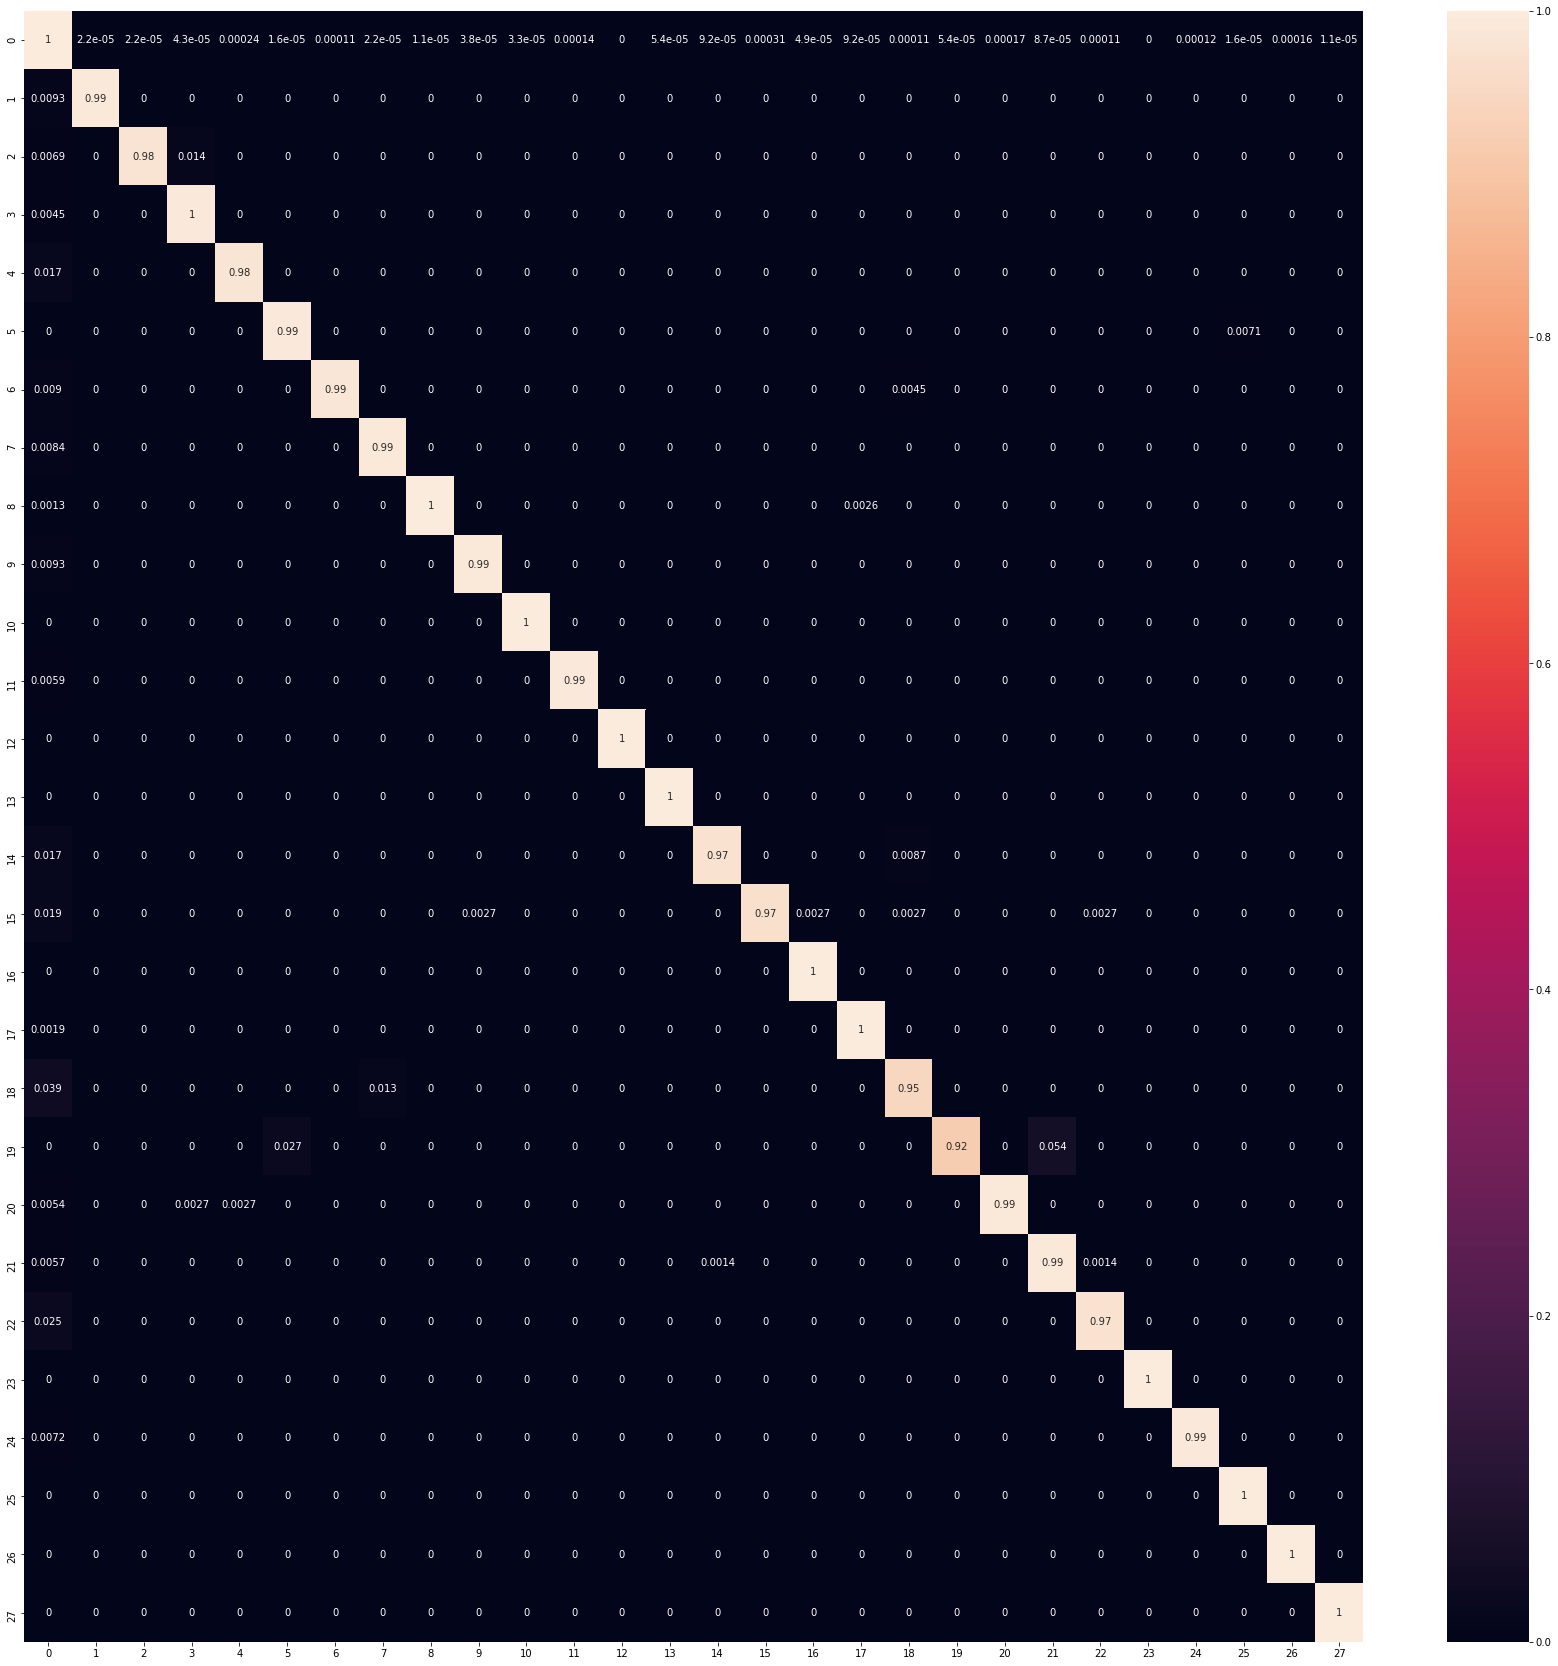

In [22]:
# test_data = text_dataset(extracted_text=all_comps.loc[12,'Text'],cluster_dict=cluster_dict,dataset_type='test')
# test_dl = DataLoader(test_data,batch_size=5,shuffle=False,collate_fn=model.collate_fn)

val_outs = []
val_targets = []
device = torch.device('cpu')
model = model.to(device)
for inputs,targets,sentence_lens in tqdm(dataloaders['val']):
    inputs = inputs.to(device)
    sentence_lens = torch.tensor(sentence_lens,dtype=torch.long,device=device)
    with torch.no_grad():
        outputs = model(inputs,sentence_lens)
        preds = torch.argmax(outputs,dim=1).flatten()
        val_outs.append(preds)
        val_targets.append(targets.flatten())

print(set(torch.cat(val_outs).numpy()))
print(len(set(torch.cat(val_outs).numpy())))
print(set(torch.cat(val_targets).numpy()))
print(len(set(torch.cat(val_targets).numpy())))

consol_val_preds = torch.cat(val_outs)
consol_val_tgts = torch.cat(val_targets)
cm_idxs = max(len(set(consol_val_preds.numpy())),len(set(consol_val_tgts.numpy())))
print(cm_idxs)
kappa = cohen_kappa_score(consol_val_preds,consol_val_tgts)
print(f'Kappa score : {kappa}\n')
cm = confusion_matrix(consol_val_tgts.cpu(),consol_val_preds.cpu(),normalize='true')
df_cm = pd.DataFrame(cm, index = [i for i in range(cm_idxs)],
                     columns = [i for i in range(cm_idxs)])
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 12.49it/s]


{0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28}
26
{0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 12, 14, 16, 18, 20, 21, 22, 25, 26, 27, 28}
21
26
Kappa score : 0.7208702162426414



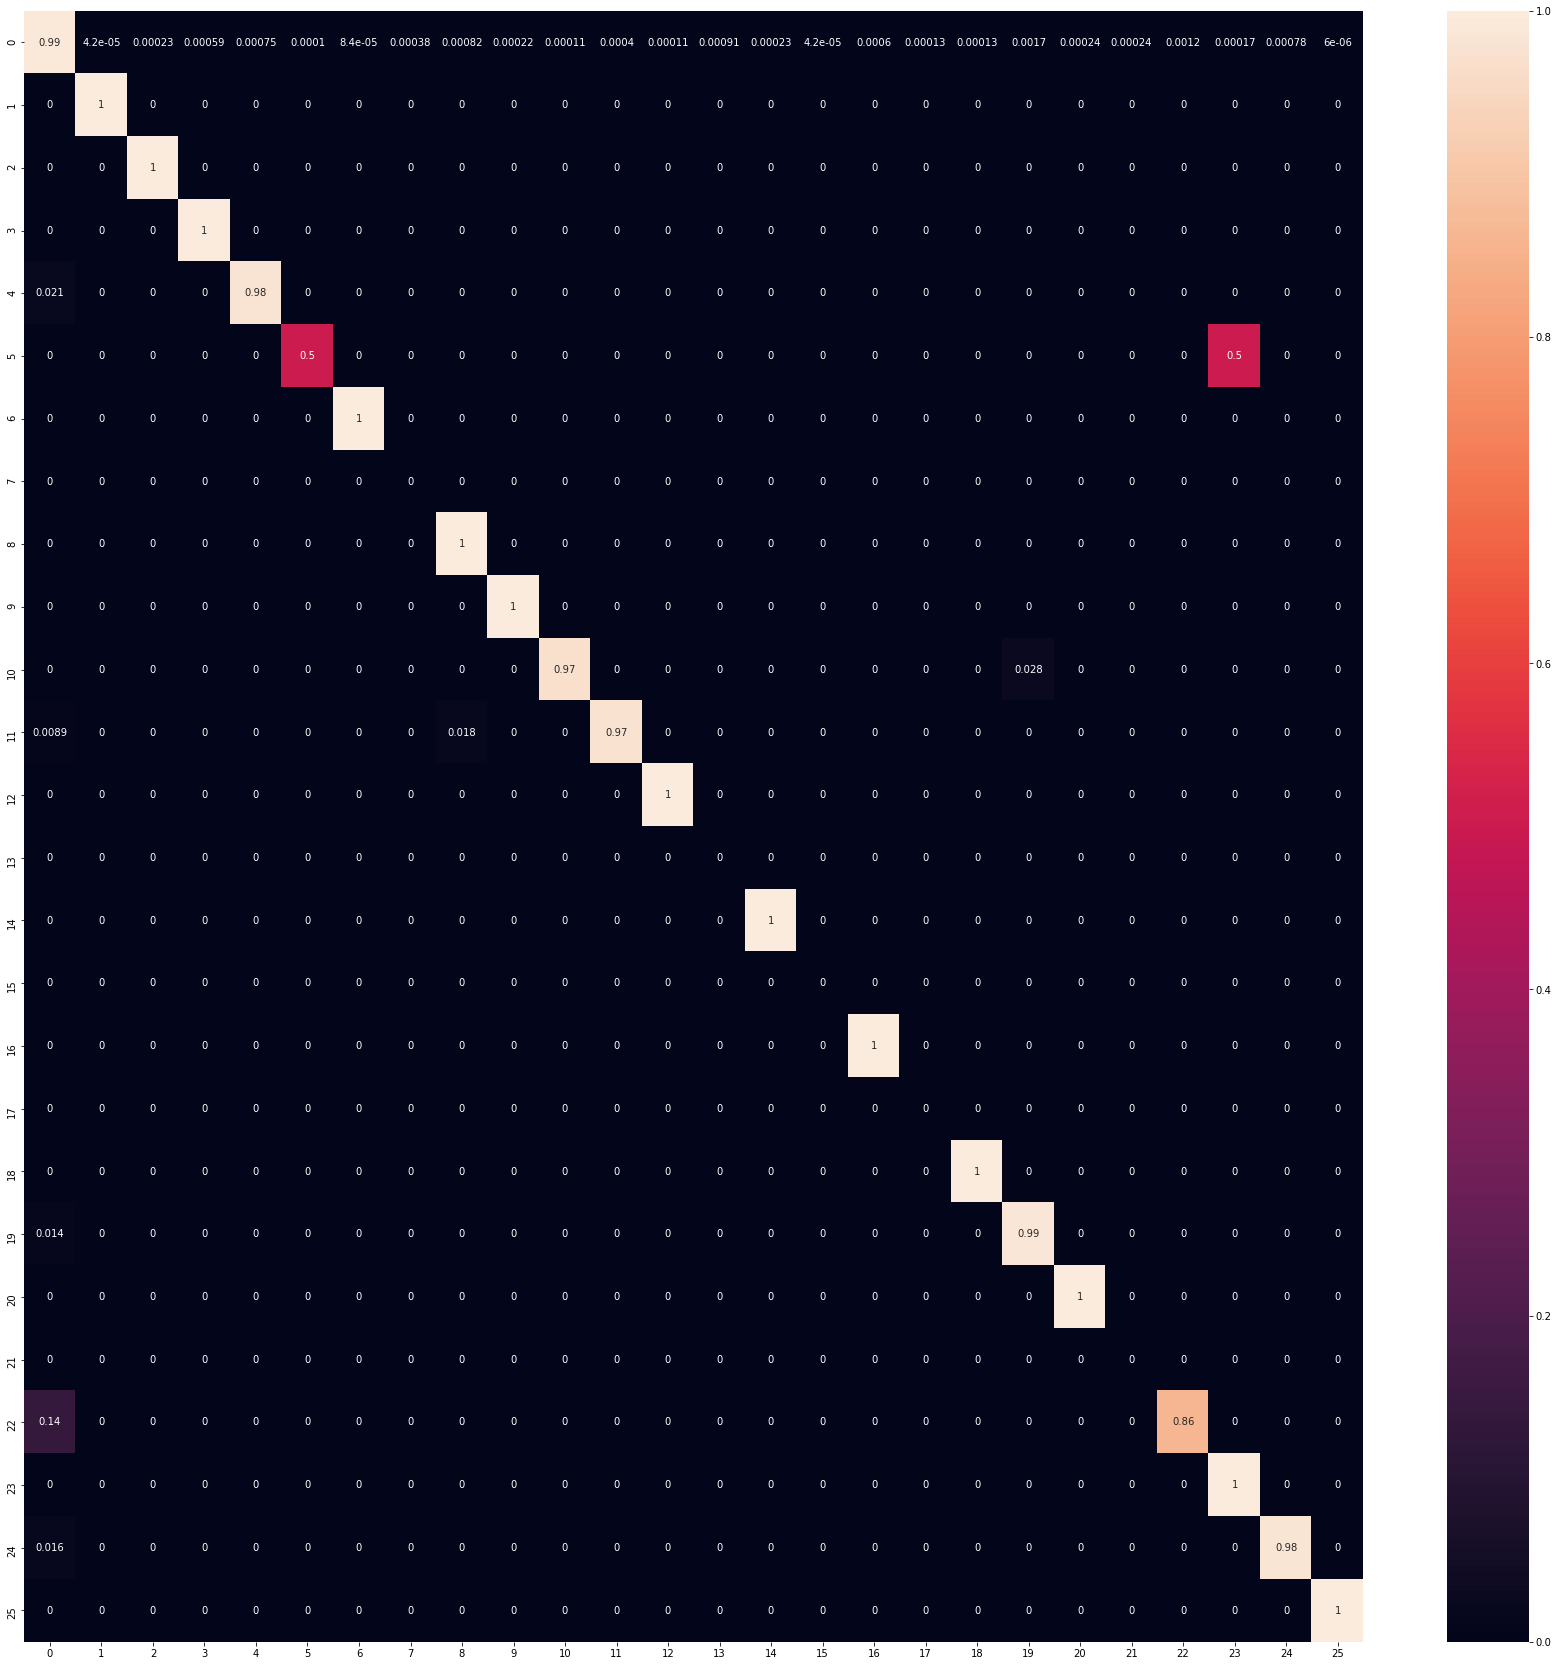

In [25]:
test_data = text_dataset(full_vocab=trial_vocab,extracted_text=all_comps.loc[0,'Text'],cluster_dict=cluster_dict,dataset_type='test')
test_dl = DataLoader(test_data,batch_size=100,shuffle=False,collate_fn=model.collate_fn)

val_outs = []
val_targets = []
device = torch.device('cpu')
model = model.to(device)
for inputs,targets,sentence_lens in tqdm(test_dl):
    inputs = inputs.to(device)
    sentence_lens = torch.tensor(sentence_lens,dtype=torch.long,device=device)
    with torch.no_grad():
        outputs = model(inputs,sentence_lens)
        preds = torch.argmax(outputs,dim=1).flatten()
        val_outs.append(preds)
        val_targets.append(targets.flatten())

print(set(torch.cat(val_outs).numpy()))
print(len(set(torch.cat(val_outs).numpy())))
print(set(torch.cat(val_targets).numpy()))
print(len(set(torch.cat(val_targets).numpy())))

consol_val_preds = torch.cat(val_outs)
consol_val_tgts = torch.cat(val_targets)
cm_idxs = max(len(set(consol_val_preds.numpy())),len(set(consol_val_tgts.numpy())))
print(cm_idxs)
kappa = cohen_kappa_score(consol_val_preds,consol_val_tgts)
print(f'Kappa score : {kappa}\n')
cm = confusion_matrix(consol_val_tgts.cpu(),consol_val_preds.cpu(),normalize='true')
df_cm = pd.DataFrame(cm, index = [i for i in range(cm_idxs)],
                     columns = [i for i in range(cm_idxs)])
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00, 11.05it/s]


{0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28}
26
{0, 1, 2, 3, 5, 6, 7, 9, 11, 12, 14, 15, 16, 18, 20, 21, 22, 25, 26, 27, 28}
21
26
Kappa score : 0.6462079990649572



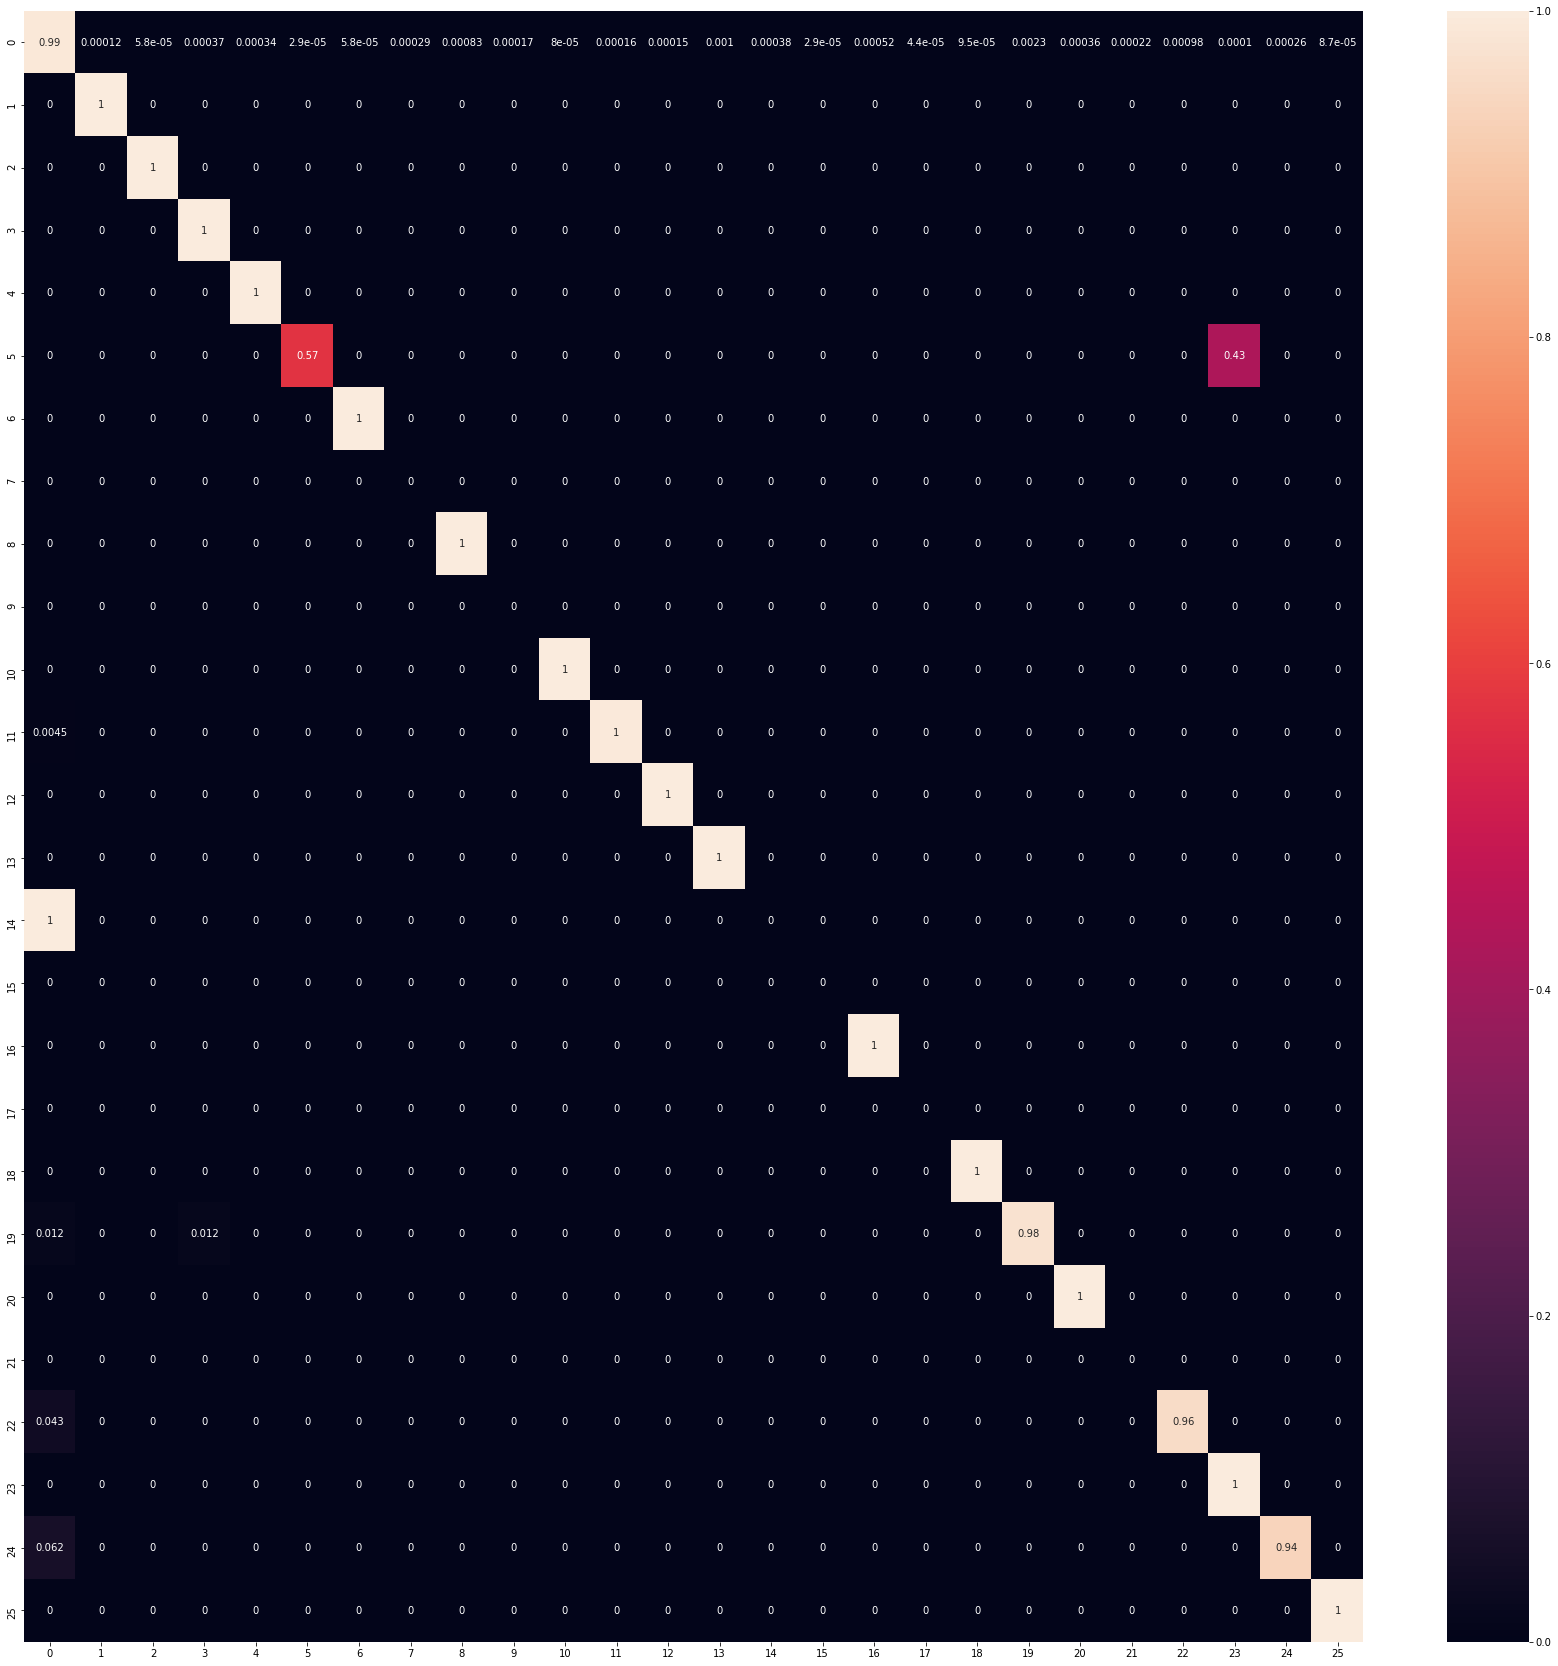

In [26]:
test_data = text_dataset(full_vocab=trial_vocab,extracted_text=all_comps.loc[1,'Text'],cluster_dict=cluster_dict,dataset_type='test')
test_dl = DataLoader(test_data,batch_size=100,shuffle=False,collate_fn=model.collate_fn)

val_outs = []
val_targets = []
device = torch.device('cpu')
model = model.to(device)
for inputs,targets,sentence_lens in tqdm(test_dl):
    inputs = inputs.to(device)
    sentence_lens = torch.tensor(sentence_lens,dtype=torch.long,device=device)
    with torch.no_grad():
        outputs = model(inputs,sentence_lens)
        preds = torch.argmax(outputs,dim=1).flatten()
        val_outs.append(preds)
        val_targets.append(targets.flatten())

print(set(torch.cat(val_outs).numpy()))
print(len(set(torch.cat(val_outs).numpy())))
print(set(torch.cat(val_targets).numpy()))
print(len(set(torch.cat(val_targets).numpy())))

consol_val_preds = torch.cat(val_outs)
consol_val_tgts = torch.cat(val_targets)
cm_idxs = max(len(set(consol_val_preds.numpy())),len(set(consol_val_tgts.numpy())))
print(cm_idxs)
kappa = cohen_kappa_score(consol_val_preds,consol_val_tgts)
print(f'Kappa score : {kappa}\n')
cm = confusion_matrix(consol_val_tgts.cpu(),consol_val_preds.cpu(),normalize='true')
df_cm = pd.DataFrame(cm, index = [i for i in range(cm_idxs)],
                     columns = [i for i in range(cm_idxs)])
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True)

In [126]:
kappa_scores = []
for i in tqdm(range(len(all_comps))):
    test_data = text_dataset(extracted_text=all_comps.loc[i,'Text'],cluster_dict=cluster_dict,dataset_type='test')
    test_dl = DataLoader(test_data,batch_size=200,shuffle=False,collate_fn=model.collate_fn)
    val_outs = []
    val_targets = []
    device = torch.device('cpu')
    model = model.to(device)
    for inputs,targets,sentence_lens in test_dl:
        inputs = inputs.to(device)
        sentence_lens = torch.tensor(sentence_lens,dtype=torch.long,device=device)
        with torch.no_grad():
            outputs = model(inputs,sentence_lens)
            preds = torch.argmax(outputs,dim=1).flatten()
            val_outs.append(preds)
            val_targets.append(targets.flatten())
    consol_val_preds = torch.cat(val_outs)
    consol_val_tgts = torch.cat(val_targets)
    kappa = cohen_kappa_score(consol_val_preds,consol_val_tgts)
    kappa_scores.append(kappa)

  0%|                                                                                          | 0/463 [00:00<?, ?it/s]C:\Users\Owner\Anaconda3\envs\cs231n\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
100%|████████████████████████████████████████████████████████████████████████████████| 463/463 [25:15<00:00,  3.27s/it]


In [127]:
print(sum(kappa_scores)/len(kappa_scores))

0.4230996372961605


In [128]:
least = [idx for idx in range(len(kappa_scores)) if kappa_scores[idx]<0.35]
least

[2,
 14,
 19,
 27,
 30,
 45,
 74,
 75,
 77,
 98,
 99,
 111,
 113,
 115,
 118,
 123,
 124,
 132,
 141,
 144,
 148,
 153,
 168,
 187,
 192,
 198,
 210,
 213,
 233,
 246,
 260,
 261,
 263,
 265,
 267,
 279,
 285,
 291,
 294,
 296,
 316,
 332,
 337,
 354,
 368,
 369,
 388,
 398,
 409,
 411,
 416,
 418,
 434,
 453,
 456,
 461]

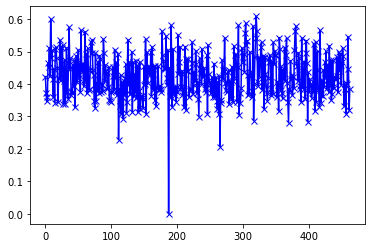

In [129]:
import matplotlib.pyplot as plt
plt.plot(list(range(len(kappa_scores))),kappa_scores,'bx-')
plt.show()

In [123]:
all_comps.loc[2,'Text']

'10-K 1 a08-22004_110k.htm 10-K Table of Contents Exact name of registrant as specified in its charter Registrants telephone number, including area code 212-572-4200 None Indicate by check mark if the registrant is a well-known seasoned issuer, as defined in Rule 405 of the Securities Act.  Yes  x   No  o Indicate by check mark if the registrant is not required to file reports pursuant to Section 13 or Section 15d of the Act.  Yes  o   No  x Indicate by check mark whether the registrant 1 has filed all reports required to be filed by Section 13 or 15d of the Securities Exchange Act of 1934 during the preceding 12 months or for such shorter period that the registrant was required to file such reports, and 2 has been subject to such filing requirements for the past 90 days.  Yes  x   No  o Indicate by check mark if disclosure of delinquent filers pursuant to Item 405 of Regulation S-K is not contained herein, and will not be contained, to the best of registrants knowledge, in definitive 

In [530]:
fval_words = []
fval_preds = []
for inputs,targets,sentence_lens in tqdm(dataloaders['val']):
    inputs = inputs.to(device)
    sentence_lens = torch.tensor(sentence_lens,dtype=torch.long,device=device)
    with torch.no_grad():
        outputs = model(inputs,sentence_lens)
        preds = torch.argmax(outputs,dim=1).permute(1,0)
        words = inputs.flatten()
        word_preds = preds.flatten()
        for i in range(words.size()[0]):
            if words[i].item() != 0:
                fval_words.append(train_data.vocabulary.idx2word[words[i].item()])
                fval_preds.append(word_preds[i].item())

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:26<00:00,  1.68it/s]


In [533]:
cluster_preds = {}
for i in range(29):
    cluster_preds[i]=[]
for word,pred in zip(fval_words,fval_preds):
    cluster_preds[pred].append(word)
for i in range(29):
    cluster_preds[i]=list(set(cluster_preds[i]))

In [541]:
file1 = open('first_run_preds.pkl','wb')
pickle.dump(cluster_preds,file1)
file1.close()
file2 = open('first_run_og.pkl','wb')
pickle.dump(cluster_dict,file2)
file2.close()

In [559]:
x = 16
print(cluster_preds[x])
print(cluster_dict[x])

['wgi', 'biotic', 'hypoxemia', 'stee', 'whe', 'lampitt', 'calcify', 'lakebeds', 'milly', 'illustrative', 'arr', 'rng', 'chroniclers', 'seasonality', 'situ', 'plagues', 'multiscale', 'ellie', 'ottmar', 'cloudier', 'pauline', 'wm', 'avoidable', 'sérgio', 'homeostatic', 'dx', 'stimulatory', 'inversely', 'cdr', 'bathypelagic', 'cece', 'troposphere', 'berkes', 'chem', 'exacerbation', 'breakpoints', 'modulations', 'poleward', 'ei', 'continuations', 'attributional', 'neutralization', 'localized', 'hsd', 'priori', 'scaler', 'eal', 'concessional', 'gnv', 'disrupts', 'timescale', 'huxleyi', 'insolation', 'raper', 'photosystem', 'borehole', 'susanne', 'regulary', 'nuttall', 'typologies', 'constrains', 'overestimation', 'limacina', 'skiba', 'hore', 'gf', 'nonlinear', 'baselines', 'phenology', 'upwelling', 'tor', 'sio', 'thickening', 'hwp', 'urbanization', 'vv', 'reto', 'renner', 'wanninkhof', 'lemelin', 'modifies', 'gridded', 'biophysical', 'timescales', 'arbuscula', 'porites', 'depletions', 'thre